# Notebook de modélisation de SiteEnergyUse


## Import des Librairies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn import linear_model
import timeit
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


In [3]:
data = pd.read_csv('cleanData.csv')

In [4]:
firsColumn = data.pop('Age')
data.insert(2, 'Age', firsColumn) 

In [5]:
data

,BuildingType,PrimaryPropertyType,Age,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,TotalGHGEmissions,SiteEnergyUse_log
0,NonResidential,Mixed Use Property,89,7,DOWNTOWN,1.0,2.0,52549.0,65.416836,583.41,7.192677
1,NonResidential,Mixed Use Property,13,7,MAGNOLIA / QUEEN ANNE,1.0,4.0,110785.0,65.416836,91.53,7.025666
2,NonResidential,Small- and Mid-Sized Office,109,7,DOWNTOWN,1.0,6.0,98370.0,45.000000,47.24,6.814640
3,NonResidential,Large Office,68,7,LAKE UNION,1.0,4.0,193788.0,59.000000,116.84,7.224280
4,NonResidential,Small- and Mid-Sized Office,7,2,GREATER DUWAMISH,1.0,3.0,76598.0,76.000000,134.69,6.650987
...,...,...,...,...,...,...,...,...,...,...,...
1260,NonResidential,Other,1,2,GREATER DUWAMISH,1.0,2.0,108036.0,65.416836,91.98,6.698265
1261,NonResidential,Other,3,4,NORTHEAST,1.0,1.0,72000.0,65.416836,67.65,6.466242
1262,NonResidential,K-12 School,1,3,GREATER DUWAMISH,1.0,3.0,45000.0,77.000000,9.24,6.122535
1263,NonResidential,Mixed Use Property,1,7,LAKE UNION,1.0,6.0,345290.0,65.416836,1000.06,7.595101


### Sélection des features

In [6]:
datacopy = data.copy()
datacopy1 = data.copy()

In [7]:
datacopy = datacopy.drop(['ENERGYSTARScore'], axis=1)

### Split du dataset et encodage des variables catégorielles

In [8]:
target = ['TotalGHGEmissions','SiteEnergyUse_log']

In [9]:
X = datacopy.drop(target, axis=1).values
y = datacopy['SiteEnergyUse_log'].values
z = datacopy['TotalGHGEmissions'].values



In [10]:
V = datacopy1.drop(target, axis=1).values
t = datacopy1['SiteEnergyUse_log'].values

In [11]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X_0 = LabelEncoder()
X[:, 4] = labelencoder_X_0.fit_transform(X[:, 4])
X[:, 0] = labelencoder_X_0.fit_transform(X[:, 0])
X[:, 1] = labelencoder_X_0.fit_transform(X[:, 1])

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [13]:
from sklearn.preprocessing import LabelEncoder

labelencoder_V_0 = LabelEncoder()
V[:, 4] = labelencoder_V_0.fit_transform(V[:, 4])
V[:, 0] = labelencoder_V_0.fit_transform(V[:, 0])
V[:, 1] = labelencoder_V_0.fit_transform(V[:, 1])
from sklearn.model_selection import train_test_split
V_train, V_test, y_train, y_test = train_test_split(V, t, test_size = 0.2, random_state = 1)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
V_train= sc.fit_transform(V_train)
V_test = sc.transform(V_test)

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
model_comparison = pd.DataFrame()

In [16]:
influenceESS=pd.DataFrame() 

### Définition des fonctions des modèles

#### Fonction d'estimation des meilleurs paramètres

Pour éviter les répétitions, la fonction gridsearchCV est créée. Elle permet d'utiliser la fonction gridsearchCV de sklearn pour tester différentes combinaisons d'hyperparamètres et de pouvoir extraire les hyperparamètres associés au meilleur R².

In [17]:
# Définir la fonction gridsearchresult pour obtenir les meilleurs hyperparamètre des différents modèle tester
def gridsearchresults(model, param_grid, X_train, y_train, X_test, y_test):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=3, n_jobs=-1)
    
    # Ajuster sur les différentes combinaisons de GridSearchCV
    grid_result = grid.fit(X_train, y_train)
    
    #Afficher les meilleurs scores (r²) et meilleurs paramètres
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    
    #Calculer les métrics avec sklearn.metrics et les afficher
    mse = metrics.mean_squared_error(y_test, grid.predict(X_test))
    rmse = np.sqrt(mse) #mse**(0.5)  
    r2 = metrics.r2_score(y_test, grid.predict(X_test))
    
    print("Results of sklearn.metrics:")
    print("RMSE:", rmse)
    print("R-Squared:", r2)

#### Fonction d'évaluation des métriques

La fonction suivante calcule les diverses métriques que l'on souhaite interpréter: Mean Absolute error (MAE), Root Mean Squarred Error (RMSE), le R squared et enfin le temps de test des combinaisons; et les retourne dans un dictionnaire.

In [18]:
def calcul_metrics(model,X_train, y_train, X_test, y_test):   
    #Calculer les métrics avec sklearn.metrics et les afficher
    mae = metrics.mean_absolute_error(y_test, model.predict(X_test))
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    rmse = np.sqrt(mse) #mse**(0.5)  
    r2 = metrics.r2_score(y_test, model.predict(X_test))
    score = model.score(X_train, y_train)

    
    print("Results of sklearn.metrics:")
    print("Score:", score)
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)
    
    return dict(Score= score, r2 = r2, RMSE = rmse, MAE = mae)

## Régression linéaire

### Régression linéaire classique

In [19]:
lr  = linear_model.LinearRegression()

# Calculer le temps d'entraînement 
start_time = timeit.default_timer()

# Ajuster les paramètres par rapport au données d'entraînements
lr = lr.fit(X_train, y_train)

duration_lr = timeit.default_timer() - start_time

# Afficher le temps d'entraînement
print ('Durée {:.2f}s'.format(duration_lr))

# Calculer les métriques du modèles et créer un dictionnaire de ces données à insérer dans un df
lr_result = calcul_metrics(lr,X_train, y_train, X_test, y_test)
model_comparison = model_comparison.append(lr_result, ignore_index=True)

Durée 0.28s
Results of sklearn.metrics:
Score: 0.4447805507674947
MAE: 0.36551807437914163
MSE: 0.22216881598454274
RMSE: 0.47134787151799334
R-Squared: 0.33700750407900926


In [20]:
model_comparison

,Score,r2,RMSE,MAE
0,0.444781,0.337008,0.471348,0.365518


#### SVR Regression

In [21]:
from sklearn.svm import LinearSVR
svr = LinearSVR()

param_grid = {'C' : np.logspace(-4, 0, 5),
             'epsilon' : [ 0.01, 0.1, 0.5, 1, 2],
             'loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'max_iter': [100, 1000, 10000]}

In [22]:
gridsearchresults(svr, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best Score:  0.3417072372304819
Best Params:  {'C': 0.1, 'epsilon': 0.01, 'loss': 'epsilon_insensitive', 'max_iter': 100}
Results of sklearn.metrics:
RMSE: 0.4678650258597446
R-Squared: 0.3467691666013578


C:\Users\hp\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
#Récupérer les meilleurs paramètres suggérés ci-dessus et les renseigner dans modèle
svr = LinearSVR( epsilon=0.01, tol=0.0001, C=0.1, loss='epsilon_insensitive', max_iter= 1000)
start_time = timeit.default_timer()

#Ajuster les données avec le meilleur paramètre recommandé
svr = svr.fit(X_train, y_train)

#Calculer le temps d'entraînement du modèle
duration_svr = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_svr))


Durée 0.01s


In [24]:
svr_result = calcul_metrics(svr,X_train, y_train, X_test, y_test)


Results of sklearn.metrics:
Score: 0.42646977929327146
MAE: 0.35993949636854194
MSE: 0.21883935809011115
RMSE: 0.46780269140964886
R-Squared: 0.3469432171074598


In [25]:
model_comparison = model_comparison.append(svr_result, ignore_index=True)

### Random Forest Regressor

#### Estimation des meilleurs paramètres

Dans un premier temps, la librairie RandomizedSearchCV permet de tester aléatoirement quelques combinaisons d'hyperparamètres proposés ci-dessous pour réduire le nombre de valeurs à tester par hyperparamètre des modèles et donc le temps d'entraînement sur les différents combinaisons avec GridSearchCV.

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [int(x) for x in np.linspace (start = 2, stop = X_train.shape[1], num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [10, 50, 100, 300, 500]
min_samples_leaf = [5, 25, 50, 150, 250]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [2, 2, 3, 4, 4, 5, 6, 6, 7, 8], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [10, 50, 100, 300, 500], 'min_samples_leaf': [5, 25, 50, 150, 250], 'bootstrap': [True, False]}


In [27]:

rfr = RandomForestRegressor()

rfr_random = RandomizedSearchCV(
    estimator = rfr, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1)
rfr_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [2, 2, 3, 4, 4, 5, 6, 6,
                                                         7, 8],
                                        'min_samples_leaf': [5, 25, 50, 150,
                                                             250],
                                        'min_samples_split': [10, 50, 100, 300,
                                                              500],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                    

In [28]:
rfr_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 3,
 'max_depth': 60,
 'bootstrap': False}

In [29]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40, 50, 60],
    'max_features':[3],
    'min_samples_leaf': [10, 20, 40, 50, 60],
    'min_samples_split': [10, 20, 40],
    'n_estimators': [600, 800]
}

rfr = RandomForestRegressor()

In [30]:
gridsearchresults(rfr, param_grid, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Score:  0.655791114099326
Best Params:  {'bootstrap': False, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 600}
Results of sklearn.metrics:
RMSE: 0.37184986204402687
R-Squared: 0.5873700362381278


#### Modéliser avec les meilleurs paramètres

In [31]:
rfr =  RandomForestRegressor(bootstrap= False, 
                             max_depth= 40, 
                             max_features= 3, 
                             min_samples_leaf= 10, 
                             min_samples_split=10, 
                             n_estimators= 800)
start_time = timeit.default_timer()
rfr = rfr.fit(X_train, y_train)
duration_rfr = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_rfr))

Durée 3.92s


In [32]:
rfr_result = calcul_metrics(rfr,X_train, y_train, X_test, y_test)

Results of sklearn.metrics:
Score: 0.7780484824681154
MAE: 0.27294478758092083
MSE: 0.13860196455718923
RMSE: 0.3722928478458715
R-Squared: 0.5863863161258558


In [33]:
model_comparison = model_comparison.append(rfr_result, ignore_index=True)

In [34]:
influenceESS=influenceESS.append(rfr_result, ignore_index=True)

## Comparaison des modèles

In [35]:
duration = [duration_lr, duration_svr, duration_rfr]
modele = ['Reg Lin','SVR', 'RandomForest', ]

In [36]:
model_comparison['duration'] = duration

In [37]:
model_comparison

,Score,r2,RMSE,MAE,duration
0,0.444781,0.337008,0.471348,0.365518,0.281515
1,0.426470,0.346943,0.467803,0.359939,0.009502
2,0.778048,0.586386,0.372293,0.272945,3.920399


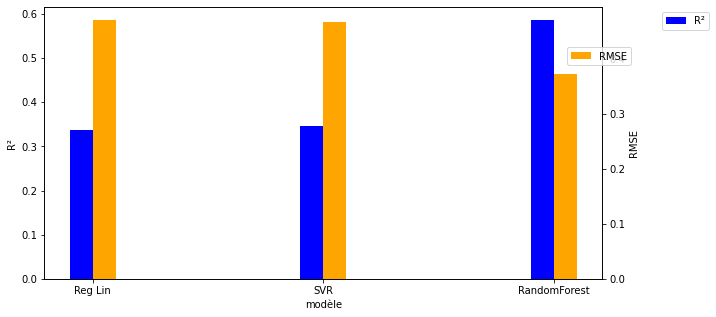

In [53]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.1
ind = np.arange(len(model_comparison))
ax.set_ylabel('R²')
ax2.set_ylabel("RMSE")
ax.set_xlabel('modèle')
ax.bar(ind, model_comparison.r2, width, color='blue', label = 'R2')
ax2.bar(ind + width, model_comparison.RMSE, width, color = 'orange', label = "RMSE")
ax.set(xticks = (ind + 0.5 * width), xticklabels = modele)
ax.legend(['R²'], bbox_to_anchor = (1.2, 1))
ax2.legend(["RMSE"], bbox_to_anchor = (1.06, 0.87))
plt.show()

## Effet de l'EnergyStarScore 

In [39]:
from sklearn.preprocessing import LabelEncoder

labelencoder_V_0 = LabelEncoder()
V[:, 4] = labelencoder_V_0.fit_transform(V[:, 4])
V[:, 0] = labelencoder_V_0.fit_transform(V[:, 0])
V[:, 1] = labelencoder_V_0.fit_transform(V[:, 1])
from sklearn.model_selection import train_test_split
V_train, V_test, t_train, t_test = train_test_split(V, t, test_size = 0.2, random_state = 1)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
V_train= sc.fit_transform(V_train)
V_test = sc.transform(V_test)

In [40]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [int(x) for x in np.linspace (start = 2, stop = X_train.shape[1], num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [10, 50, 100, 300, 500]
min_samples_leaf = [5, 25, 50, 150, 250]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators, 
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [2, 2, 3, 4, 4, 5, 6, 6, 7, 8], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [10, 50, 100, 300, 500], 'min_samples_leaf': [5, 25, 50, 150, 250], 'bootstrap': [True, False]}


In [41]:
rfrV = RandomForestRegressor()
rfr_random = RandomizedSearchCV(
    estimator = rfr, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1)
rfr_random.fit(V_train, t_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(bootstrap=False,
                                                   max_depth=40, max_features=3,
                                                   min_samples_leaf=10,
                                                   min_samples_split=10,
                                                   n_estimators=800),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [2, 2, 3, 4, 4, 5, 6, 6,
                                                         7, 8],
                                        'min_samples_leaf': [5, 25, 50, 150,
                                                             250

In [42]:
rfr_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 4,
 'max_depth': 70,
 'bootstrap': False}

In [43]:
param_grid = {
    'bootstrap': [False],
    'max_depth': [10, 20, 30, 40, 50, 60],
    'max_features':[4],
    'min_samples_leaf': [10, 20, 40, 50, 60],
    'min_samples_split': [10, 20, 40],
    'n_estimators': [600, 1800]
}
rfrV = RandomForestRegressor()

In [44]:
gridsearchresults(rfrV, param_grid, V_train, t_train, V_test, t_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best Score:  0.7053971343094895
Best Params:  {'bootstrap': False, 'max_depth': 60, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 600}
Results of sklearn.metrics:
RMSE: 0.3489005535842361
R-Squared: 0.636730589304271


In [45]:
rfrV =  RandomForestRegressor(bootstrap= False, 
                             max_depth= 40, 
                             max_features= 4, 
                             min_samples_leaf= 10, 
                             min_samples_split=10, 
                             n_estimators= 600)
start_time = timeit.default_timer()
rfrV = rfrV.fit(V_train, t_train)
duration_rfr = timeit.default_timer() - start_time
print('Durée {:.2f}s'.format(duration_rfr))

Durée 2.47s


In [46]:
rfr_resultV = calcul_metrics(rfrV,V_train, t_train, V_test, t_test)

Results of sklearn.metrics:
Score: 0.8251125430942217
MAE: 0.24869602421156833
MSE: 0.12257389968267941
RMSE: 0.3501055550582987
R-Squared: 0.6342170014938426


In [47]:
influenceESS=influenceESS.append(rfr_resultV, ignore_index=True)

In [48]:
influenceESS

,Score,r2,RMSE,MAE
0,0.778048,0.586386,0.372293,0.272945
1,0.825113,0.634217,0.350106,0.248696


In [49]:
modele1 = ['SansESS', 'AvecESS']

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='r2'>

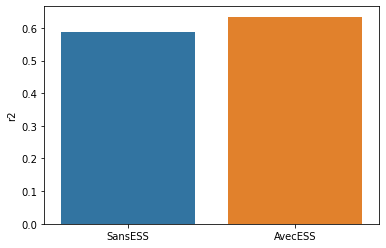

In [50]:
sns.barplot(modele1, influenceESS.r2)

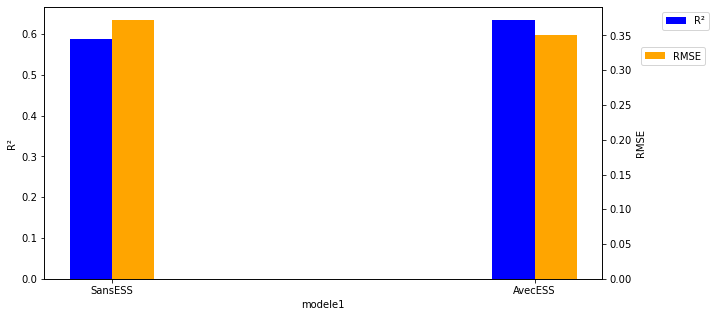

In [54]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
width = 0.1
ind = np.arange(len(influenceESS))
ax.set_ylabel('R²')
ax2.set_ylabel("RMSE")
ax.set_xlabel('modele1')
ax.bar(ind, influenceESS.r2, width, color='blue', label = 'R²')
ax2.bar(ind + width, influenceESS.RMSE, width, color = 'orange', label = "RMSE")
ax.set(xticks = (ind + 0.5 * width), xticklabels = modele1)
ax.legend(['R²'], bbox_to_anchor = (1.2, 1))
ax2.legend(["RMSE"], bbox_to_anchor = (1.06, 0.87))
plt.show()